## Import required packages

In [1]:
import os
import tifffile
import numpy as np
import math

%load_ext autoreload

## Set the paths to images

In [2]:
work_dir = os.getcwd()
examples_dir = os.path.dirname(work_dir)
mitochondria_dir = os.path.join(examples_dir, 'images', 'mitochondria')
IMAGE_PATH = os.path.join(mitochondria_dir, 'ASY15-1_0nM-10_s10_mNeon.tif')
LABELS_PATH = os.path.join(mitochondria_dir, 'ASY15-1_0nM-10_s10_segm.npz')
IMAGE_PATH

'g:\\My Drive\\01_Postdoc_HMGU\\Python_MyScripts\\MIA\\Git\\spotMAX_v2\\examples\\images\\mitochondria\\ASY15-1_0nM-10_s10_mNeon.tif'

## Load images
Load the spots image and the segmentation data of the cells (`lab`)

In [3]:
image = tifffile.tifffile.imread(IMAGE_PATH)
image.shape, image.dtype

((43, 377, 377), dtype('uint8'))

In [4]:
lab = np.load(LABELS_PATH)['arr_0']
lab.shape, lab.dtype

((377, 377), dtype('uint32'))

## Visualize max projection of loaded data

Text(0.5, 1.0, 'Segmented cells')

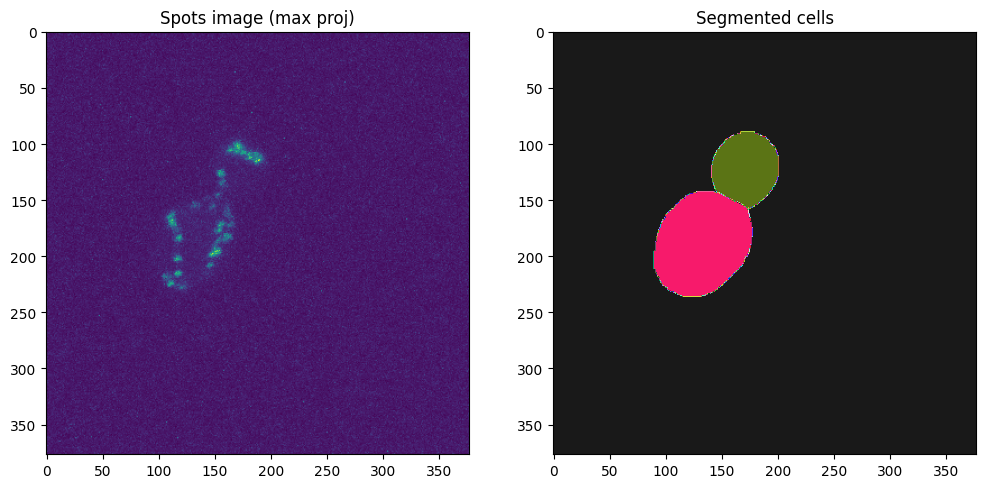

In [5]:
import matplotlib.pyplot as plt
import matplotlib

spots_img_max = image.max(axis=0)

fig, ax = plt.subplots(1, 2, figsize=(12,8))
ax[0].imshow(spots_img_max)
ax[0].set_title('Spots image (max proj)')

random_colors = np.random.rand(256,3)
# Dark color for background
random_colors[0] = (0.1, 0.1, 0.1)
cmap = matplotlib.colors.ListedColormap(random_colors)

ax[1].imshow(lab, cmap=cmap)
ax[1].set_title('Segmented cells')

## Segment the spots
By segmenting the spots image we get a mask where to detect the spots. 

This is a **crucial step**. It is worth testing all the available methods which are several algortithms for automatic thresholding, the spotMAX neural network, and any of the models from the [BioImage.IO Model Zoo](https://bioimage.io).

Here we show how to visualize the result for all the methods and proceed with the selected one. 

In [6]:
# Initialize kwargs in case they are not initialized in the next cells
nnet_model = None
nnet_params = None

bioimageio_model = None
bioimageio_params = None

### Initialize spotMAX neural network

In [7]:
import spotmax.nnet.model

nnet_model = spotmax.nnet.model.Model(
    model_type='2D',
    preprocess_across_experiment=False,
    preprocess_across_timepoints=False,
    gaussian_filter_sigma=0,
    remove_hot_pixels=False, 
    PhysicalSizeX=0.073,
    resolution_multiplier_yx=1.0,
    use_gpu=False,
)
nnet_params = {
    'segment': {
        'threshold_value': 0.9,
        'label_components': False
    }
}

### Initialize BioImage.IO model

When using the DOI or the URL of the model, BioImage.IO will download the model to the path defined in the environment variable called "BIOIMAGEIO_CACHE_PATH". The default is your local temp folder which means that your downloaded models might be removed by your OS when it clears the temp files. To keep the model, we set the download folder to the folder where this notebook is located. 

In [8]:
notebook_path = work_dir
bioimageio_models_path = os.path.join(notebook_path, 'bioimageio_models')
os.environ["BIOIMAGEIO_CACHE_PATH"] = bioimageio_models_path

from bioimageio.spec.shared.common import BIOIMAGEIO_CACHE_PATH
BIOIMAGEIO_CACHE_PATH

c:\Users\Francesco\.virtualenvs\acdc\lib\site-packages\bioimageio\spec\shared\_resolve_source.py:440: CacheWarning: found cached g:\My Drive\01_Postdoc_HMGU\Python_MyScripts\MIA\Git\spotMAX_v2\examples\notebooks\bioimageio_models\https\raw.githubusercontent.com\bioimage-io\bioimage.io\main\site.config.json. Skipping download of https://raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)
c:\Users\Francesco\.virtualenvs\acdc\lib\site-packages\bioimageio\spec\shared\_resolve_source.py:440: CacheWarning: found cached g:\My Drive\01_Postdoc_HMGU\Python_MyScripts\MIA\Git\spotMAX_v2\examples\notebooks\bioimageio_models\https\bioimage-io.github.io\collection-bioimage-io\collection.json. Skipping download of https://bioimage-io.github.io/collection-bioimage-io/collection.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)


WindowsPath('g:/My Drive/01_Postdoc_HMGU/Python_MyScripts/MIA/Git/spotMAX_v2/examples/notebooks/bioimageio_models')

In [11]:
import spotmax.BioImageIO.model

model_doi = '10.5281/zenodo.5764892'
bioimageio_model = spotmax.BioImageIO.model.Model(
    model_doi_url_or_zip_path=model_doi
)
bioimageio_params = {
    'segment': {
        'threshold_value': 0.9,
        'output_index': 0,
        'label_components': False
    }
}

rdf.yaml: 4.18kiB [00:00, 124kiB/s]                   
c:\Users\Francesco\.virtualenvs\acdc\lib\site-packages\bioimageio\spec\shared\_resolve_source.py:482: UserWarning: Download (4184) does not have expected size (1612).
  warnings.warn(f"Download ({t.n}) does not have expected size ({total_size}).")
c:\Users\Francesco\.virtualenvs\acdc\lib\site-packages\bioimageio\spec\shared\schema.py:46: ValidationWarning: tags: Missing tags corresponding to bioimage.io categories: [{'framework': ['tensorflow', 'pytorch', 'tensorflow.js']}, {'software': ['ilastik', 'imagej', 'fiji', 'imjoy', 'deepimagej', 'napari']}, {'method': ['stardist', 'cellpose', 'yolo', 'care', 'n2v', 'denoiseg']}]
  warnings.warn(msg, category=ValidationWarning)
c:\Users\Francesco\.virtualenvs\acdc\lib\site-packages\bioimageio\spec\shared\schema.py:46: ValidationWarning: weights:torchscript: missing 'pytorch_version'
  warnings.warn(msg, category=ValidationWarning)
zero_mean_unit_variance.ijm: 100%|██████████| 845/845 [00:0

### Segment with all the automatic thresholding methods

In [12]:
import spotmax.pipe

# Rough estimate for the radii of the spots in pixels. This can be 
# estimated visually
spots_zyx_radii_pxl = (3.5, 5, 5)

spots_segm_result = spotmax.pipe.spots_semantic_segmentation(
    image, 
    lab=lab,
    gauss_sigma=0.75,
    spots_zyx_radii_pxl=spots_zyx_radii_pxl, 
    do_sharpen=True, 
    do_remove_hot_pixels=False,
    lineage_table=None,
    do_aggregate=True,
    use_gpu=False,
    logger_func=print,
    thresholding_method=None,
    keep_input_shape=True,
    nnet_model=nnet_model,
    nnet_params=nnet_params,
    nnet_input_data=None,
    bioimageio_model=bioimageio_model,
    bioimageio_params=bioimageio_params,
    do_preprocess=True,
    do_try_all_thresholds=True,
    return_only_segm=False,
    pre_aggregated=False,
    raw_image=None
)
print('Semantic segmentation done.')

########################################
######## Model Configuration ###########
########################################
Model: unet2D
Operation: predict
Configuration:
{'model': {'name': 'UNet2D',
           'n_channels': 1,
           'n_classes': 2,
           'bilinear': True,
           'model_dir': '~/spotmax_appdata/unet_checkpoints/checkpoints/unet2D',
           'best_model_path': '~/spotmax_appdata/unet_checkpoints/unet2D/unet_best.pth',
           'training_path': '~/spotmax_appdata/unet_checkpoints/unet2D/training/'},
 'trainer': {'batch_size': 16,
             'epochs': 1,
             'learning_rate': 0.001,
             'save_checkpoint': True,
             'amp': False,
             'wandb_mode': 'disabled'},
 'default_params': {'threshold_value': 0.9}}
########################################


Semantic segmentation done.


### Visualize results of semantic segmentation
We can see that the `neural_network` probably returns the best result (all spots are segmented and non-spots area are minimized). However, `threshold_li` and `threshold_yen` are not bad either. On the other hand, the worst result is probably with `threshold_mean`. 

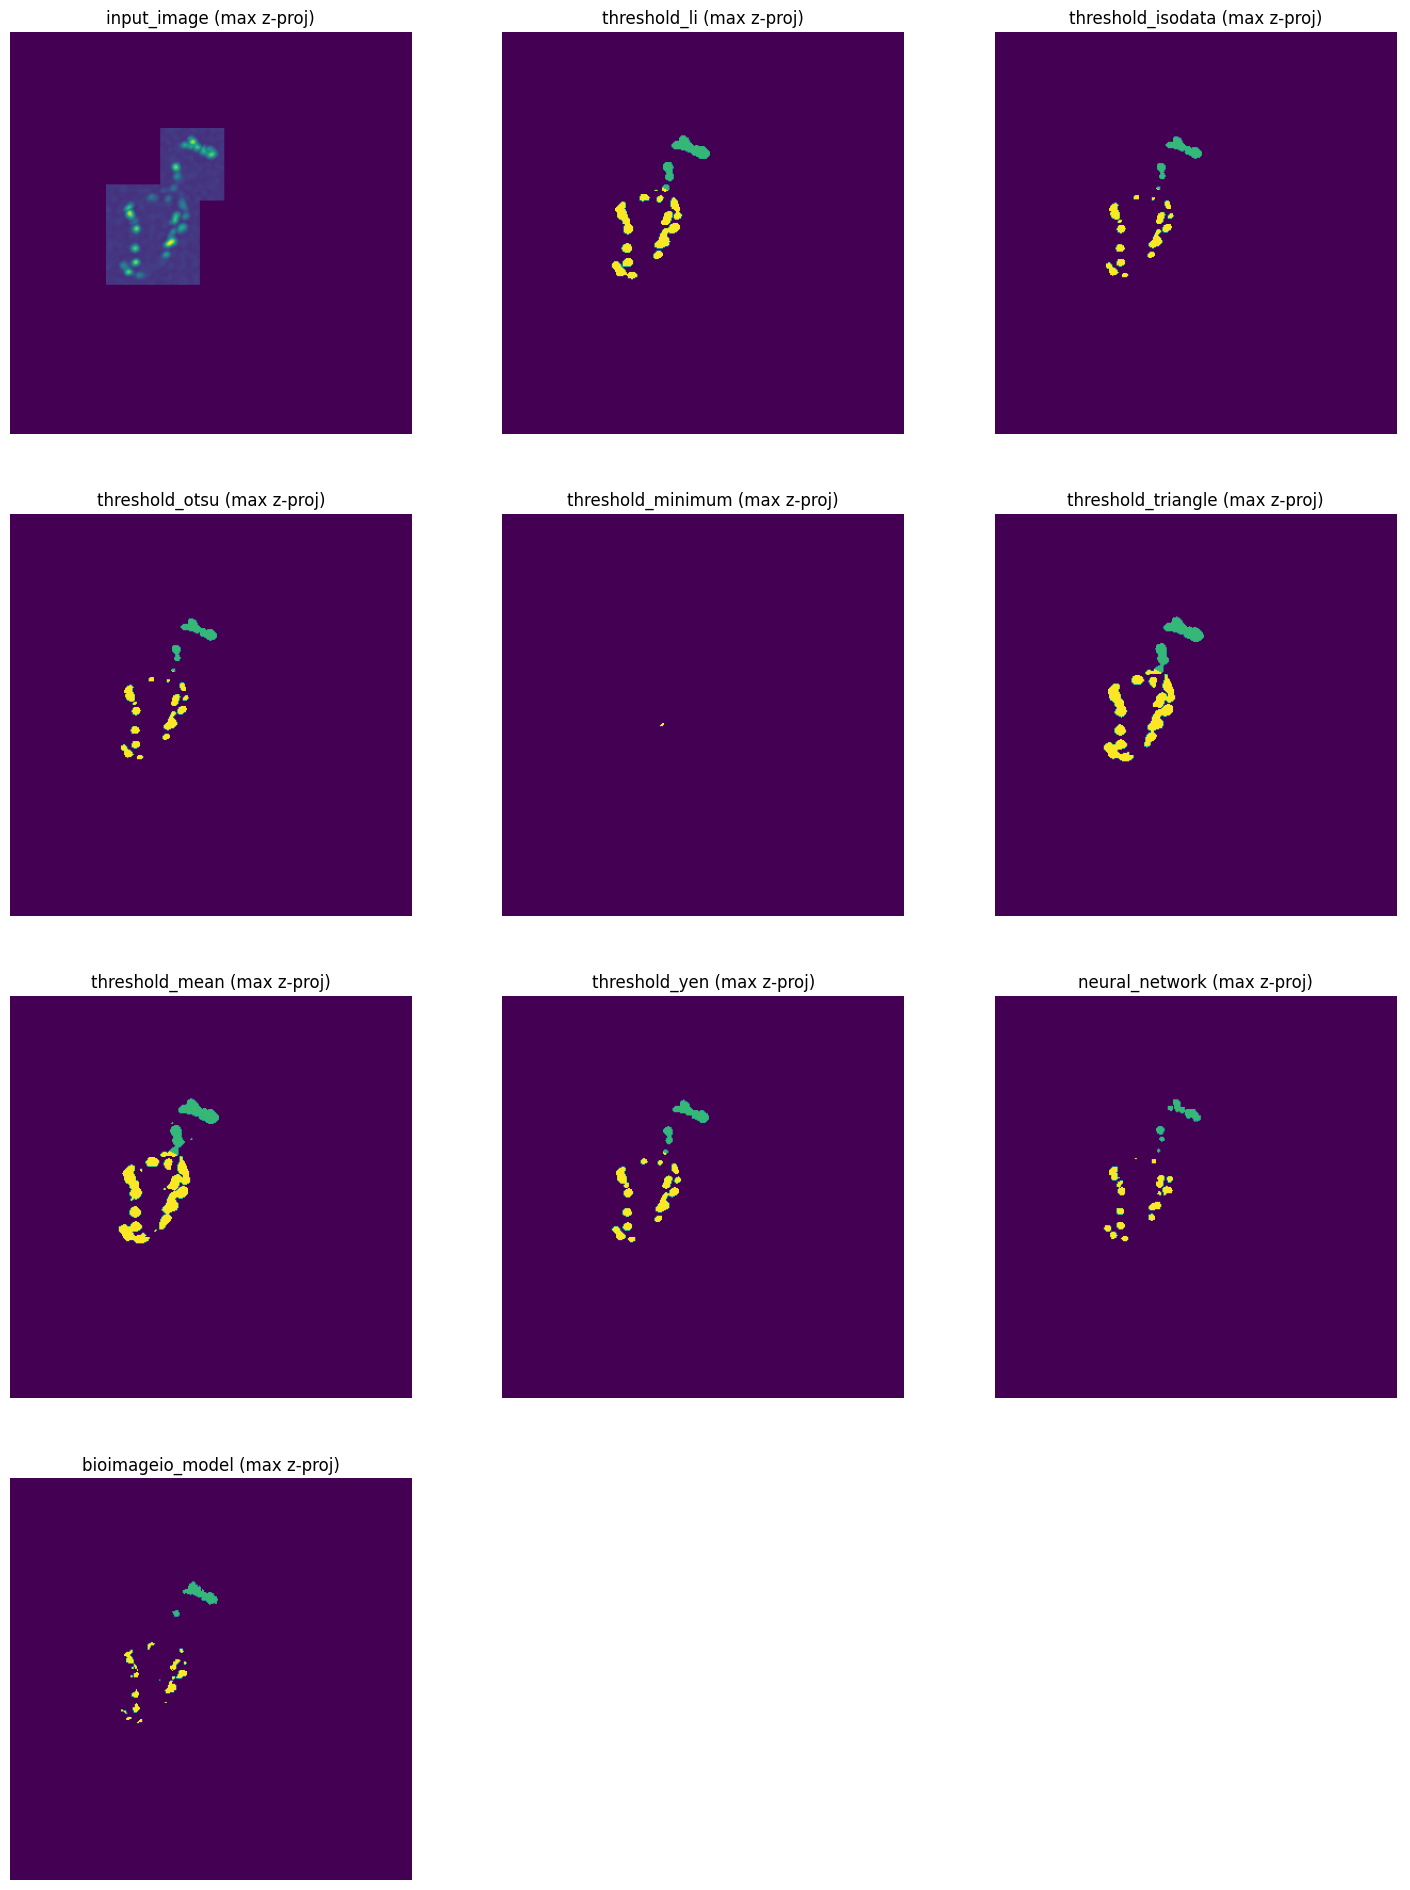

In [13]:
ncols = 3
nplots = len(spots_segm_result)
nrows = math.ceil(nplots / ncols)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6))
ax = ax.flatten()
for i, (key, img) in enumerate(spots_segm_result.items()):
    ax[i].imshow(img.max(axis=0))
    ax[i].set_title(f'{key} (max z-proj)')

for axes in ax:
    axes.axis('off')

We proceed to detect the spots using `neural_network` result. Note that if you already know which method to use you don't need to evaluate all of them, which saves quite some computation time. 

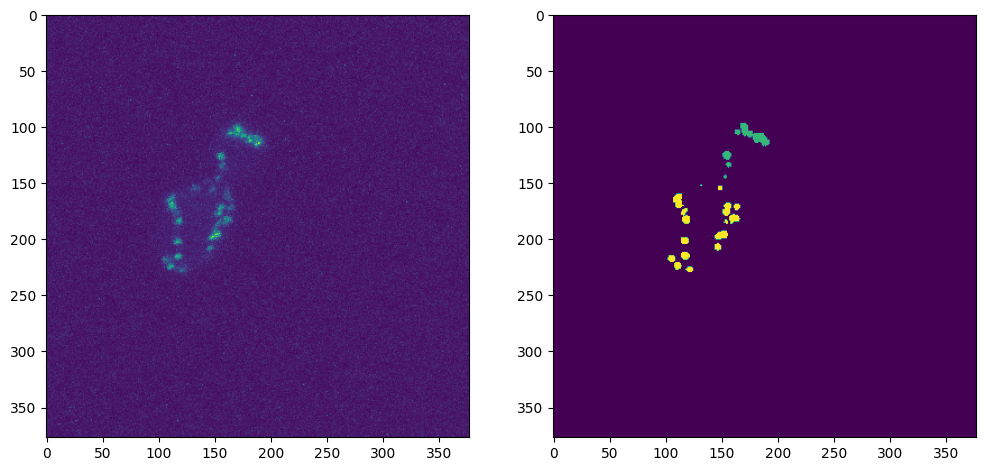

In [14]:
SELECTED_METHOD = 'neural_network'
spots_labels = spots_segm_result[SELECTED_METHOD]

fig, ax = plt.subplots(1, 2, figsize=(12,8))
ax[0].imshow(image.max(axis=0))
ax[1].imshow(spots_labels.max(axis=0))

## Detect spots

In [15]:
import pandas as pd

%autoreload 2

import spotmax.pipe

df_spots_coords, spots_masks = spotmax.pipe.spot_detection(
    spots_segm_result['input_image'],
    spots_segmantic_segm=spots_labels,
    detection_method='peak_local_max',
    spot_footprint=None,
    spots_zyx_radii_pxl=spots_zyx_radii_pxl,
    return_spots_mask=False,
    return_df=True,
    lab=lab
)

In [16]:
df_spots_coords.head(10)

,z,y,x,z_local,y_local,x_local
Cell_ID,,,,,,
2,17,102,171,17,12,30
2,22,126,155,22,36,14
2,20,114,189,20,24,48
2,14,108,175,14,18,34
2,20,111,181,20,21,40
2,20,106,170,20,16,29
2,20,106,164,20,16,23
2,21,100,169,21,10,28
2,17,110,187,17,20,46


## Visualize detected spots

Visualize on max projection

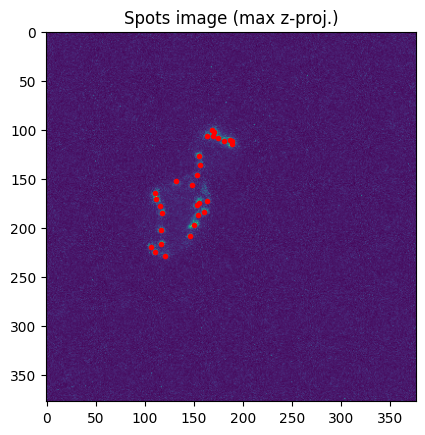

In [17]:
fig, ax = plt.subplots()

ax.imshow(image.max(axis=0))
ax.set_title('Spots image (max z-proj.)')
ax.plot(df_spots_coords['x'], df_spots_coords['y'], 'r.')

### Visualize with interactive window
Open a GUI where you can scroll through the z-slices, pan, and zoom the image.

It requires the `cellacdc` pacakge with GUI libraries and a desktop environment

In [18]:
from cellacdc.plot import imshow
imshow(image, points_coords_df=df_spots_coords)

## Filter valid spots from features

If we are not happy with the detection yet, we can filter the spots based on features such and the signal-to-noise ratio (SNR) or the size of the spots. 

Here we show how to filter based on the Effect size, which is a measure of the SNR. 

### Calculate and explore spots features
By keeping `gop_filtering_thresholds=None` we do not filter yet and we get only the features of the detected spots (as a pandas.DataFrame)

In [20]:
keys, dfs_spots_det, _ = spotmax.pipe.spots_calc_features_and_filter(
    spots_segm_result['input_image'], 
    spots_zyx_radii_pxl,
    df_spots_coords,
    frame_i=0,
    sharp_spots_image=None,
    lab=lab,
    rp=None,
    gop_filtering_thresholds=None,
    delta_tol=None,   
    raw_image=image,
    ref_ch_mask_or_labels=None, 
    ref_ch_img=None,   
    keep_only_spots_in_ref_ch=False,
    min_size_spheroid_mask=None,
    optimise_for_high_spot_density=True,
    dist_transform_spheroid=None,
    get_backgr_from_inside_ref_ch_mask=False,
    show_progress=True,
    verbose=False,
    logger_func=print
)
print('Done')

Done


In [21]:
df_features = pd.concat(dfs_spots_det, keys=keys, names=['frame_i', 'Cell_ID'])
df_features.head(10)

z    y    x  z_local  y_local  x_local  z_local_expanded  y_local_expanded  x_local_expanded  z_resolution_pxl  ...  spot_vs_backgr_ttest_pvalue  spot_vs_backgr_effect_size_cohen  backgr_effect_size_cohen_negative_mean  backgr_effect_size_cohen_negative_std  spot_vs_backgr_effect_size_glass  backgr_effect_size_glass_negative_mean  backgr_effect_size_glass_negative_std  spot_vs_backgr_effect_size_hedge  backgr_effect_size_hedge_negative_mean  backgr_effect_size_hedge_negative_std
frame_i Cell_ID spot_id                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                
0       2       1        17  102  171       17       12       30                17                22                40               3.5  ...                 2.634043e-10                          2.823375                               11.236226                               4.184516                          4.189819                               11.236226                               2.819801                          2.824149                               11.236226                               4.184516
                2        22  126  155       22       36       14                22                46                24               3.5  ...                 3.045242e-10                          2.897217                               11.739930                               3.782011                          4.628400                               11.739930                               2.367407                          2.898052                               11.739930                               3.782011
                3        20  114  189       20       24       48                20                34                58               3.5  ...                 3.430156e-10                          2.656480                               12.224656                               3.804887                          3.870634                               12.224656                               2.611356                          2.657277                               12.224656                               3.804887
                4        14  108  175       14       18       34                14                28                44               3.5  ...                 6.701579e-10                          2.948177                               12.690102                               3.028866                          4.600499                               12.690102                               1.941014                          2.948942                               12.690102                               3.028866
                5        20  111  181       20       21       40                20                31                50               3.5  ...                 2.172107e-10                          2.418310                               12.224656                               3.443391                          3.188836                               12.224656                               2.611356                          2.419036                               12.224656                               3.443391
                6        20  106  170       20       16       29                20                26                39               3.5  ...                 4.928877e-11                          2.383369                               12.224656                               3.339934                          3.048338                               12.224656                               2.611356                          2.384084                          